In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import seaborn as sns
import missingno as msn

In [34]:
def piechart(serie):
    
    value_counts = serie.value_counts()
    
    labels = value_counts.index.tolist()
    sizes = value_counts.values.tolist()
    
    fig1, ax1 = plt.subplots(figsize=(7, 7))
    ax1.pie(sizes, labels=labels, autopct='%1.2f%%')
    ax1.axis('equal') 
    plt.title(f'Distribución de "{serie.name}"')
    plt.show()
    
    return

### Lectura de los datos desde el csv

In [35]:
data = pd.read_csv('bank-additional-full.csv', na_values=['?', 'unknown', '999'], sep=';')

### Resumen de los datos. Tipo y número de valores perdidos. Dimensiones de los datos.

In [36]:
pd.DataFrame([data.dtypes, data.isnull().sum()], index=['dtype', '#nulls']).transpose()

,dtype,#nulls
age,int64,0
job,object,330
marital,object,80
education,object,1731
default,object,8597
housing,object,990
loan,object,990
contact,object,0
month,object,0
day_of_week,object,0


In [37]:
data.shape

(41188, 21)

Se agrupan las variables categóricas y numéricas en dos listas para tratamientos posteriores.

In [38]:
numeric_cols = data.select_dtypes(include=np.number).columns
object_cols = set(data.columns) - set(numeric_cols)

### 1. Descripción de las variables y valores estadísticos (mínimo, máximo, media, desviación, mediana, etc.). Estudia qué valores estadísticos son los convenientes según el tipo de variable y procede en consecuencia.

En primer lugar, se realiza una primera inspección de los datos que incluye el dataset.

In [39]:
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,NaN,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,NaN,no,no,telephone,may,mon,...,1,NaN,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,NaN,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,NaN,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,NaN,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


Para esta parte se usa la función de pandas .describe(). 

Para las variables numéricas se utilizan los estadísticos:

- media
- std
- mínimo
- máximo
- cuartiles

Para las variables categóricas se utilizan los estadísticos:

- count: numero de valores que no son null en la variable.
- unique: cuántos valores distintos toma la variable.
- top: el valor más frecuente
- freq: frecuencia absoluta del valor más frecuente.

In [40]:
data.describe(include='all').transpose().sort_values(by='unique')

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
default,32591,2,no,32588,NaN,NaN,NaN,NaN,NaN,NaN,NaN
housing,40198,2,yes,21576,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan,40198,2,no,33950,NaN,NaN,NaN,NaN,NaN,NaN,NaN
contact,41188,2,cellular,26144,NaN,NaN,NaN,NaN,NaN,NaN,NaN
y,41188,2,no,36548,NaN,NaN,NaN,NaN,NaN,NaN,NaN
marital,41108,3,married,24928,NaN,NaN,NaN,NaN,NaN,NaN,NaN
poutcome,41188,3,nonexistent,35563,NaN,NaN,NaN,NaN,NaN,NaN,NaN
day_of_week,41188,5,thu,8623,NaN,NaN,NaN,NaN,NaN,NaN,NaN
education,39457,7,university.degree,12168,NaN,NaN,NaN,NaN,NaN,NaN,NaN
month,41188,10,may,13769,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Se pintan a continuación diferentes Piecharts  para ver las distintas frecuencias de las variables categóricas.

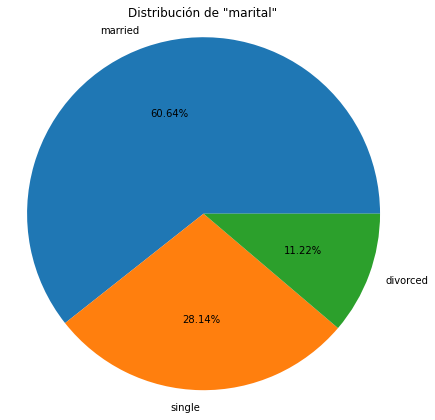

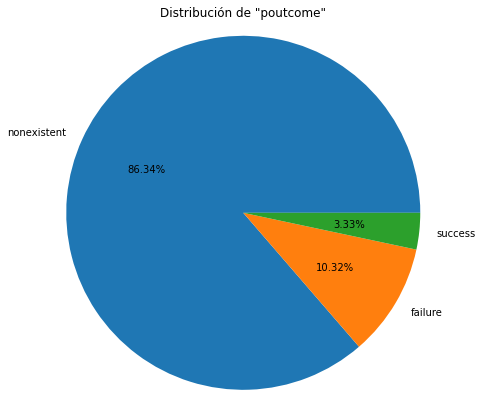

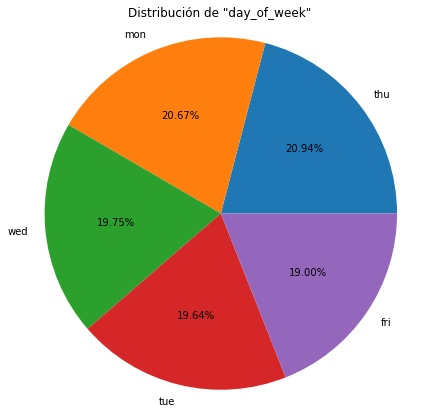

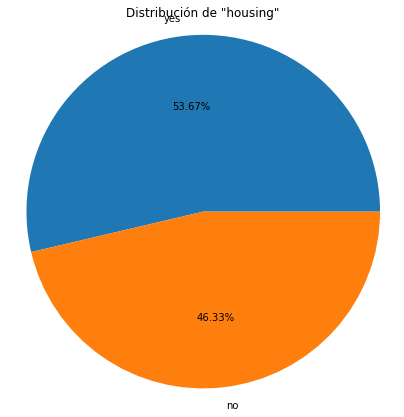

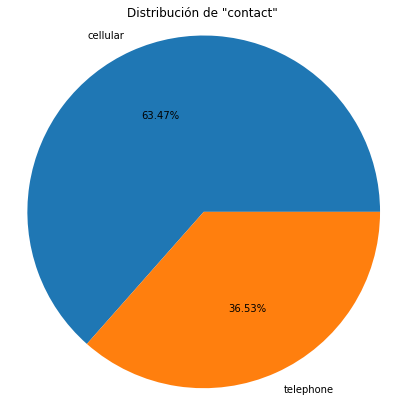

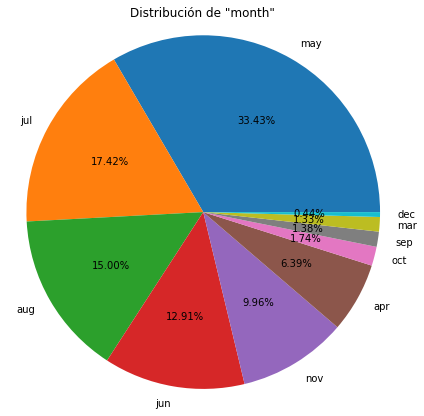

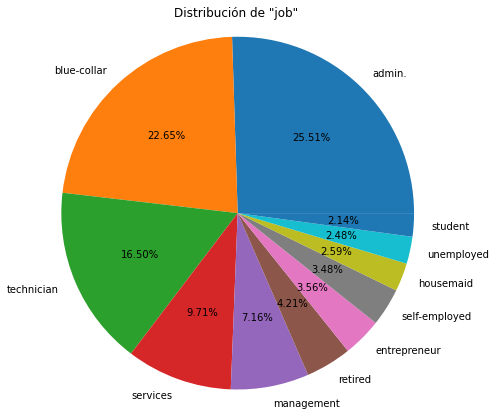

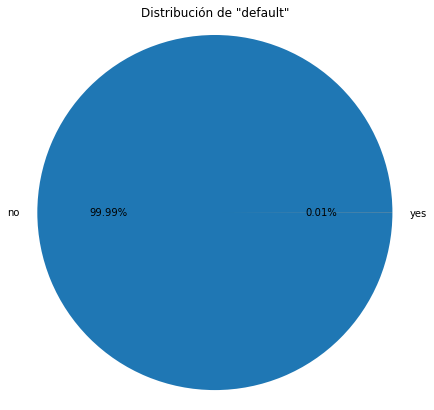

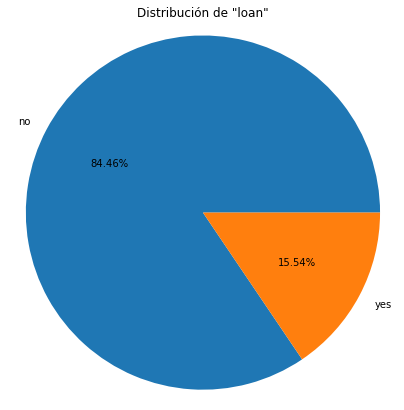

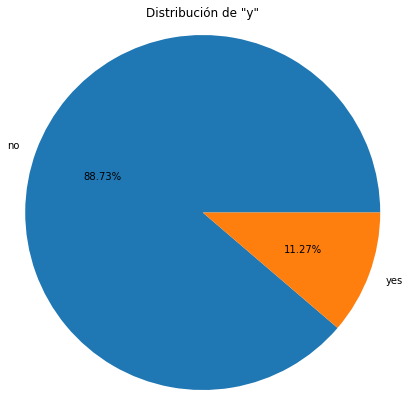

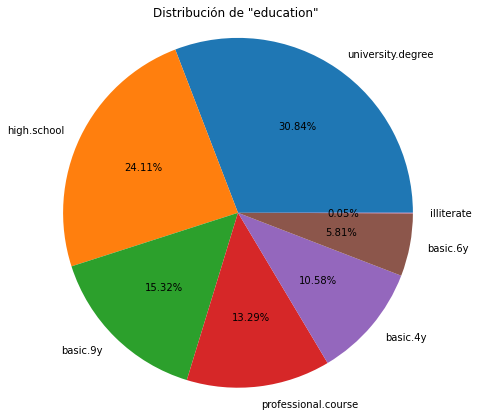

In [41]:
for col in object_cols:
    piechart(data[col])

Se observa que la variable default no aporta información, la frecuencia relativa de las personas contactadas que hacen default es del 0.01%. La variable Y, la que se supone como el output o salida del modelo, presenta una frecuencia relativa muy desfavorable para los Yes. Cuando lo ideal o esperado debería ser una proporción 50-50 (de Yes-No) para poder entrenar adecuadamente el modelo.

Por otro lado, se hace un gráfico de la función de densidad de las variables numéricas para entender su distribución, detectar posibles incosistencias y decidir qué transformaciones se pueden realizar en pasos posteriores.

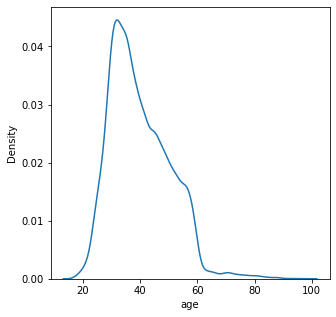

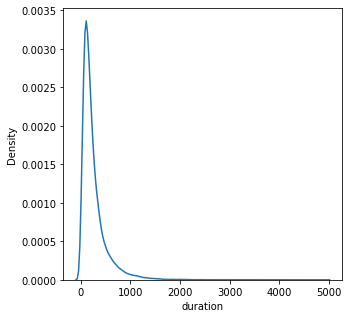

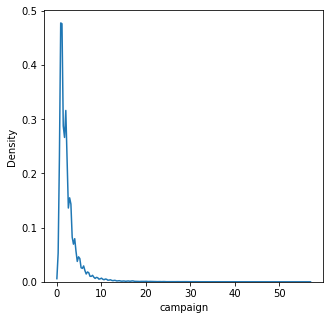

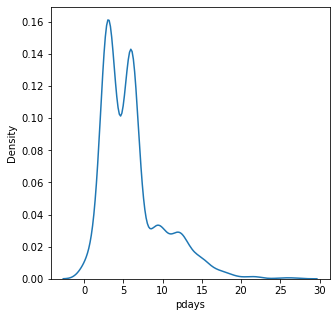

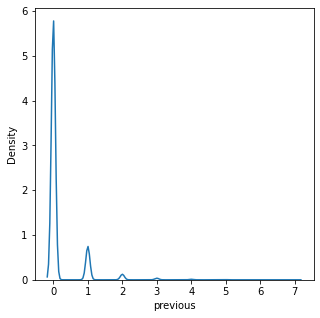

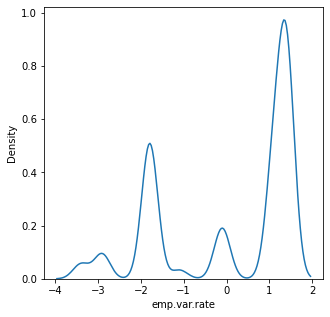

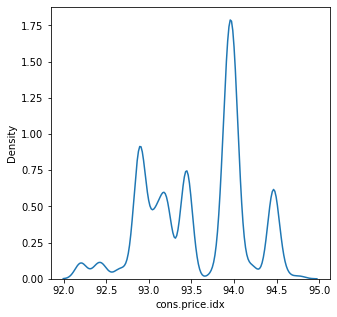

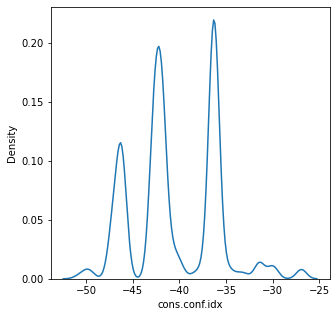

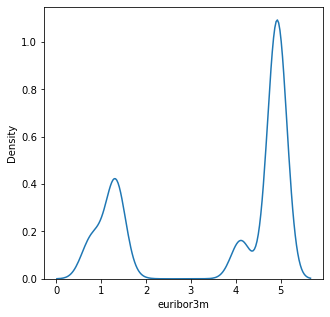

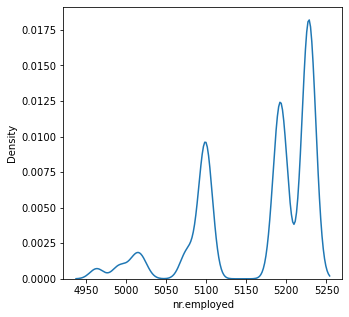

In [42]:
for col in numeric_cols:
    plt.figure(figsize=(5, 5))
    sns.kdeplot(data=data.loc[:, col])
    plt.show()

Se observa que las variables duración y campaign tienen una distribución fuertemente asimétrica hacia la derecha, se puede hipotetizar que sigue una ley potencia. Además, en general, se observa que las distribuciones son mixturas de distribuciones, algo a tener en cuenta para la posible creación de variables sintéticas mediante técnicas de clustering.

# 2 Describe y realiza modificaciones en la base datos si lo consideras necesario. Por ejemplo, qué harías con valores nominales, si los hubiera.

1. Crear dummies para las variables categoricas
2. Borrar la variable default (pocos casos, nada de info)
5. nr.employed pasarlo a categorica

### 2.1 Creación de ID de cliente

Se ha observado que el dataset no incluye ningún campo que identifique de forma única las filas.  Algo muy practico a la hora de realizar comprobaciones sobre los datos o realizar pruebas.  El identificador es simplemente un contador que incrementa en uno por cada fila del dataset.

In [43]:
data['id'] = range(len(data)) # creacion del id

In [44]:
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,id
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,NaN,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
1,57,services,married,high.school,NaN,no,no,telephone,may,mon,...,NaN,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,1
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,NaN,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,2
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,NaN,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,3
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,NaN,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,4


### 2.2 Eliminación de la variable default

Como se ha explicado en el punto anterior, la variable default resulta irrelevante para el modelo y no añade información significativa.

In [45]:
data.drop('default', axis=1, inplace=True)

### 2.3 Conversión de nr.employees a tipo entero

Se ha observado que la variable nr.employed incluye un decimal. Esto puede ser a que se ha querido adaptar la magnitud de numero de trabajadores al tamaño de la muestra. Si la muestra contaba con el 10% de todos los casos, el numero de empleados se ha dividido entre 10 para preservar algun tipo de relación numérica. Para solventar los decimales, se redondea pasando el numero a entero.

In [53]:
data['nr.employed'] = data['nr.employed'].astype(int)

### 2.4 Sustitución del caracter "." por "_" en la columna education

Se ha transformado la variable education, para sustituir en las categorías los puntos por guiones bajos. Así se puede aprovechar la funcionalidad de llamar a las columnas del dataset como atributos del objeto pandas.DataFrame y por razones de seguridad.

In [58]:
data['education'] = data['education'].apply(lambda x: x.replace('.', '_') if isinstance(x, str) else x)

### 2.5 Transformación de los valores de las variables bool a 0 y 1

# 3. Estudia si es necesario normalizar los datos y cómo lo harías. Procede a modificar la base de datos (normalizar) si lo consideras necesario.

Ordenando el resumen de las variables por el valor del máximo, se ve que las variables numéricas tienen escalas muy distintas, con una diferencia de 3 órdenes de magnitud. Para poder comparar dichas magnitudes se deberían estandarizar. Por otro lado, para buscar outliers convendría tener los valores en una escala que permita aplicar test estadísticos.

Por lo general se deberían normalizar únicamente las variables que interesen a la hora de definir un modelo, en este caso, como se desconoce el uso final que se va a dar dichas variables, se decide normalizar todas las variables numéricas.

In [14]:
data.describe(include='all').transpose().sort_values(by=['max'], ascending=False)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,41188.0,NaN,NaN,NaN,20593.5,11890.09578,0.0,10296.75,20593.5,30890.25,41187.0
nr.employed,41188.0,NaN,NaN,NaN,5167.035911,72.251528,4963.6,5099.1,5191.0,5228.1,5228.1
duration,41186.0,NaN,NaN,NaN,258.249041,259.234158,0.0,102.0,180.0,319.0,4918.0
age,41188.0,NaN,NaN,NaN,40.02406,10.42125,17.0,32.0,38.0,47.0,98.0
cons.price.idx,41188.0,NaN,NaN,NaN,93.575664,0.57884,92.201,93.075,93.749,93.994,94.767
campaign,41188.0,NaN,NaN,NaN,2.567593,2.770014,1.0,1.0,2.0,3.0,56.0
pdays,1515.0,NaN,NaN,NaN,6.014521,3.824906,0.0,3.0,6.0,7.0,27.0
previous,41188.0,NaN,NaN,NaN,0.172963,0.494901,0.0,0.0,0.0,0.0,7.0
euribor3m,41188.0,NaN,NaN,NaN,3.621291,1.734447,0.634,1.344,4.857,4.961,5.045
emp.var.rate,41188.0,NaN,NaN,NaN,0.081886,1.57096,-3.4,-1.8,1.1,1.4,1.4


In [59]:
data.loc[:, numeric_cols].head()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,56,261.0,1,NaN,0,1.1,93.994,-36.4,4.857,5191
1,57,149.0,1,NaN,0,1.1,93.994,-36.4,4.857,5191
2,37,226.0,1,NaN,0,1.1,93.994,-36.4,4.857,5191
3,40,151.0,1,NaN,0,1.1,93.994,-36.4,4.857,5191
4,56,307.0,1,NaN,0,1.1,93.994,-36.4,4.857,5191


In [16]:
scaler = StandardScaler()
scaler.fit(data.loc[:, numeric_cols])
data.loc[:, numeric_cols] = scaler.transform(data.loc[:, numeric_cols])

In [17]:
data.describe(include='all').transpose().sort_values(by=['max'], ascending=False)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
campaign,41188.0,NaN,NaN,NaN,0.0,1.000012,-0.565922,-0.565922,-0.204909,0.156105,19.289818
duration,41186.0,NaN,NaN,NaN,0.0,1.000012,-0.996212,-0.602741,-0.301851,0.234351,17.975284
previous,41188.0,NaN,NaN,NaN,0.0,1.000012,-0.349494,-0.349494,-0.349494,-0.349494,13.794918
age,41188.0,NaN,NaN,NaN,0.0,1.000012,-2.209365,-0.76998,-0.194227,0.669404,5.56331
pdays,1515.0,NaN,NaN,NaN,-0.0,1.00033,-1.572982,-0.78839,-0.003798,0.257733,5.488346
cons.conf.idx,41188.0,NaN,NaN,NaN,-0.0,1.000012,-2.224953,-0.474791,-0.280328,0.886447,2.939106
cons.price.idx,41188.0,NaN,NaN,NaN,-0.0,1.000012,-2.374889,-0.864955,0.299457,0.722722,2.058168
id,41188.0,NaN,NaN,NaN,0.0,1.000012,-1.732009,-0.866004,0.0,0.866004,1.732009
nr.employed,41188.0,NaN,NaN,NaN,-0.0,1.000012,-2.815697,-0.940281,0.33168,0.84517,0.84517
emp.var.rate,41188.0,NaN,NaN,NaN,-0.0,1.000012,-2.216433,-1.197935,0.648092,0.839061,0.839061


Se observa que las varibales despues de la transformacion se pueden comparar más facilmente al tener la misma escala. Por otro lado, por sencillez, se ha ajustado el estandarizador sobre toda la matriz de datos en lugar de sobre cada columna, algo que puede limitar el uso de la estandarización.

# 4. Detección de valores extremos (outliers) y descripción de qué harías en cada caso.

Revisitar esta sección.

<AxesSubplot:>

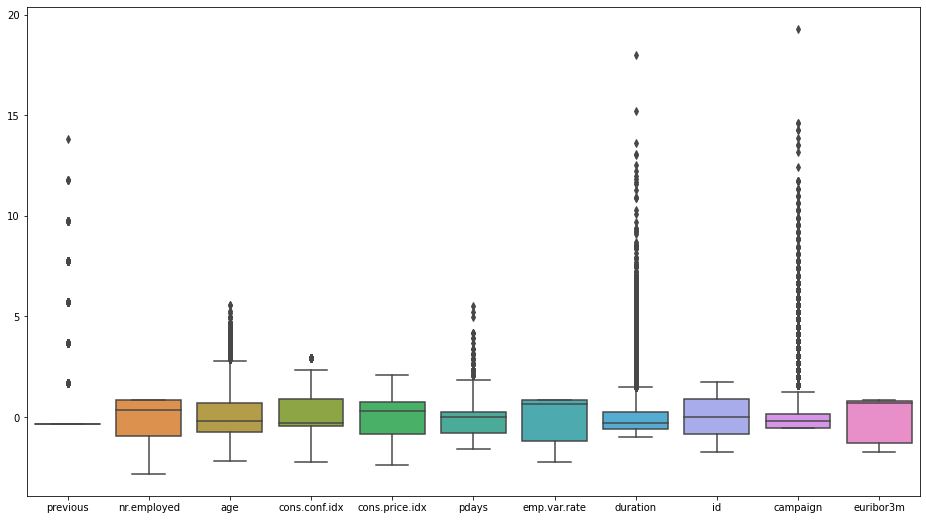

In [18]:
plt.figure(figsize=(16, 9))
sns.boxplot(data=data.loc[:, set(numeric_cols)-set('id')])

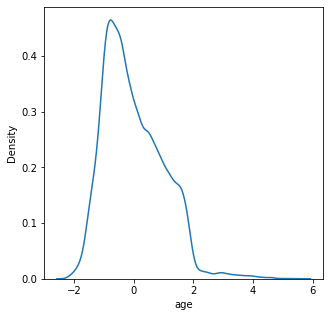

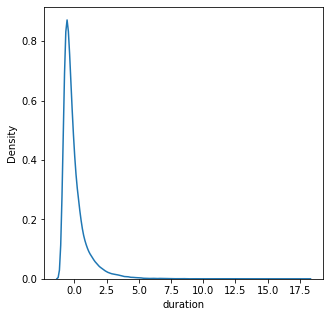

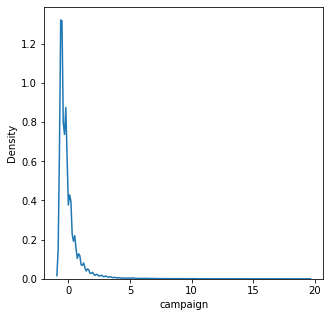

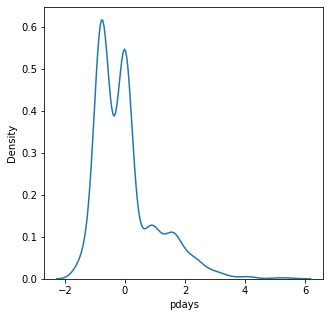

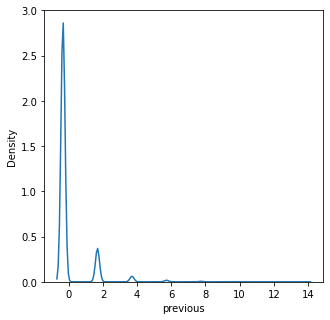

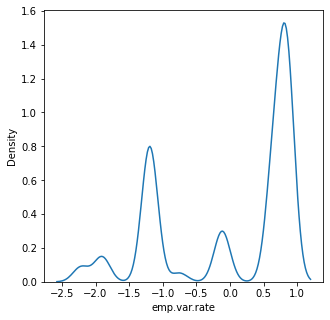

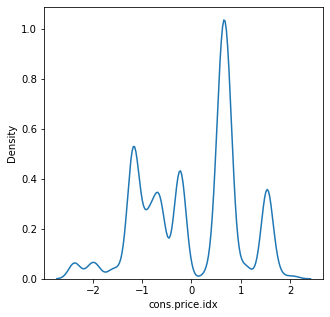

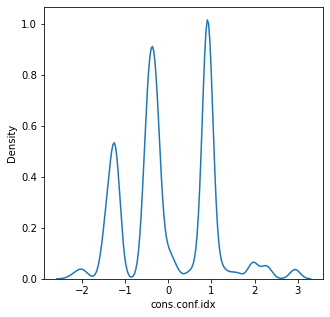

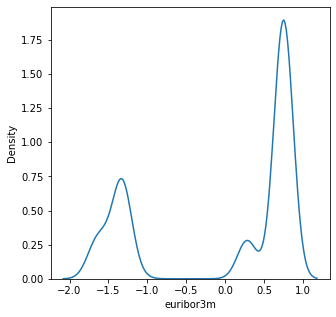

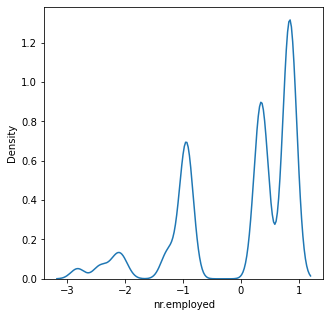

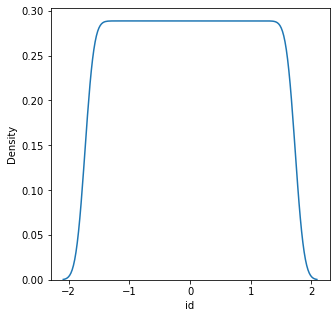

In [19]:
for col in numeric_cols:
    plt.figure(figsize=(5, 5))
    sns.kdeplot(data=data.loc[:, col])
    plt.show()

In [20]:
data['euribor3m'].value_counts()

 0.712460    2868
 0.772999    2613
 0.773575    2487
 0.772422    1902
 0.711883    1210
             ... 
 0.133594       1
 0.161269       1
-1.529203       1
-1.536699       1
 0.027507       1
Name: euribor3m, Length: 316, dtype: int64

# 5. Detección de valores perdidos (missing values) y descripción de cómo actuarías para solventar el problema.

<AxesSubplot:>

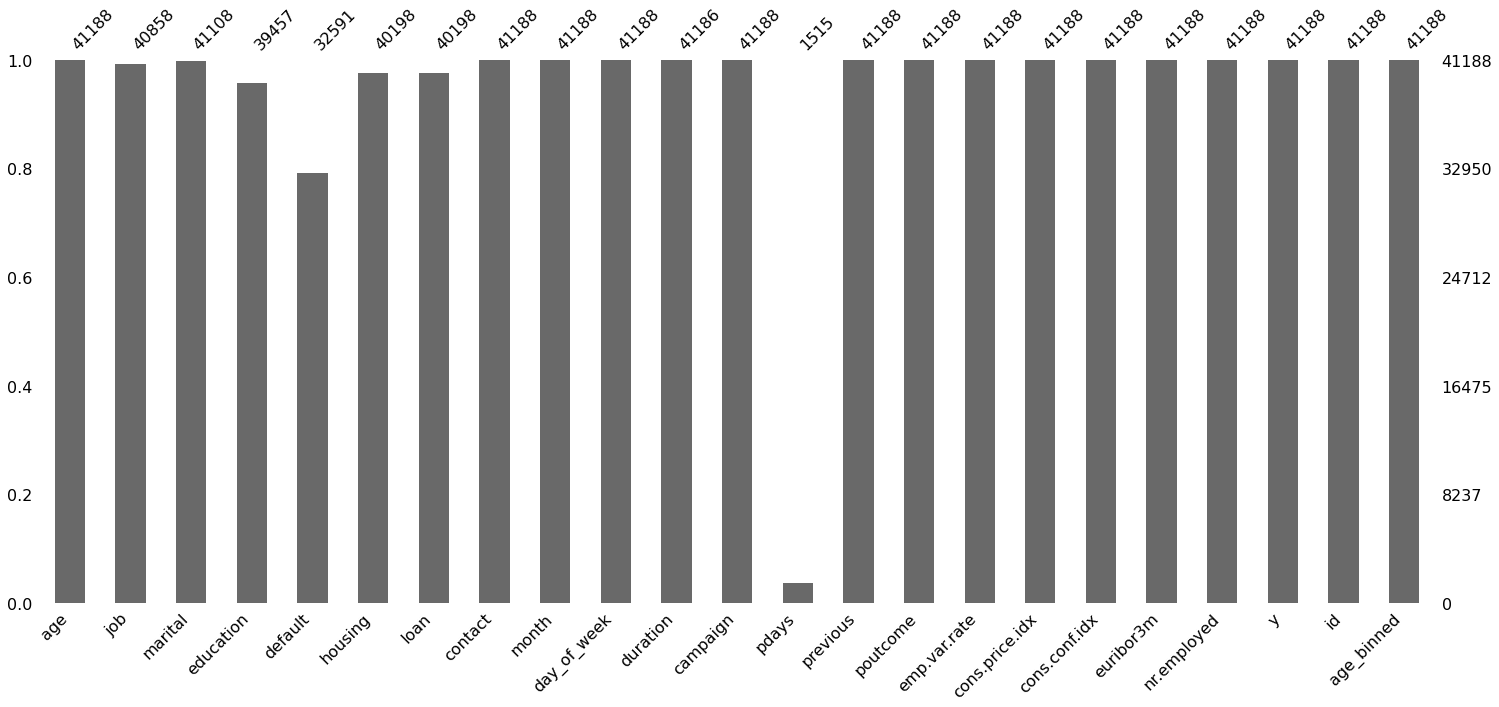

In [21]:
msn.bar(data)

- rellenar con la media: loan, housing y duration
- rellenar con la moda: marital, educacion y job
- default: rellenar con 0
- pdays: es missing pero por no ha habido contacto, no se rellena.


# 6. Buscar correlaciones entre:
    ◦ las variables predictoras, lo que permitirá ver si hay variables redundantes.
    ◦ variables predictoras y la clase (target).

# 7. Detecta, si hubiera, falsos predictores.

<AxesSubplot:xlabel='cons.price.idx', ylabel='Density'>

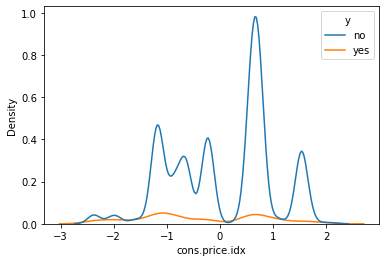

In [22]:
sns.kdeplot(data=data, x='cons.price.idx', hue='y')

In [23]:
data['y_num'] = data['y'].apply(lambda x: 1 if x=='yes' else 0)

In [24]:
data.corr()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,id,y_num
age,1.000000,-0.000832,0.004594,-0.069608,0.024365,-0.000371,0.000857,0.129372,0.010767,-0.017725,0.003910,0.030399
duration,-0.000832,1.000000,-0.071710,0.076897,0.020693,-0.028077,0.005222,-0.008203,-0.033007,-0.044794,0.008654,0.405224
campaign,0.004594,-0.071710,1.000000,0.045752,-0.079141,0.150754,0.127836,-0.013733,0.135133,0.144095,-0.093589,-0.066357
pdays,-0.069608,0.076897,0.045752,1.000000,-0.040022,0.153113,0.172140,-0.083046,-0.081574,-0.136870,0.118927,-0.035223
previous,0.024365,0.020693,-0.079141,-0.040022,1.000000,-0.420489,-0.203130,-0.050936,-0.454494,-0.501333,0.427815,0.230181
emp.var.rate,-0.000371,-0.028077,0.150754,0.153113,-0.420489,1.000000,0.775334,0.196041,0.972245,0.906970,-0.834661,-0.298334
cons.price.idx,0.000857,0.005222,0.127836,0.172140,-0.203130,0.775334,1.000000,0.058986,0.688230,0.522034,-0.737559,-0.136211
cons.conf.idx,0.129372,-0.008203,-0.013733,-0.083046,-0.050936,0.196041,0.058986,1.000000,0.277686,0.100513,-0.257615,0.054878
euribor3m,0.010767,-0.033007,0.135133,-0.081574,-0.454494,0.972245,0.688230,0.277686,1.000000,0.945154,-0.850484,-0.307771
nr.employed,-0.017725,-0.044794,0.144095,-0.136870,-0.501333,0.906970,0.522034,0.100513,0.945154,1.000000,-0.758164,-0.354678


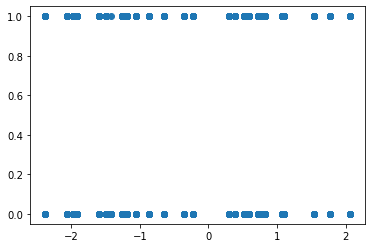

In [25]:
plt.scatter(x=data['cons.price.idx'], y=data['y_num'])

# 8. Estudia si fuera conveniente segmentar alguna de las variables.

2. Crear categorica con la edad
3. pdays: Con contacto y sin contacto

In [30]:
bins = [0, 25, 65, 200]
data['age_binned'] = pd.cut(data['age'], bins)
data['age_binned'].value_counts()

(25, 65]     38903
(0, 25]       1666
(65, 200]      619
Name: age_binned, dtype: int64

# 9. Estudia si fuera conveniente crear nuevas variables sintéticas basada en las variables originales.

- Si es poblacion activa, población no activa.
- Sin educacion o con educacion

## Conclusiones

Comentar que las fechas son importantes. Por ejemplo, al comparar vendedores, no se sabe en que fecha se mide el resultadod e llamadas y si tiene relacion con la crisis de 2008.

- Revisar correlaciones de housing con el resto de variables